# Pre-amble

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Setup

In [4]:
PATH = "data/dogscats/"
sz = 224

# Sanity testing

Check GPU is available:

In [5]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

# Explore the data

In [10]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [13]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [19]:
cats = os.listdir(f'{PATH}valid/cats')[:5]
cats

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

In [20]:
img = plt.imread(f'{PATH}valid/cats/{cats[0]}')

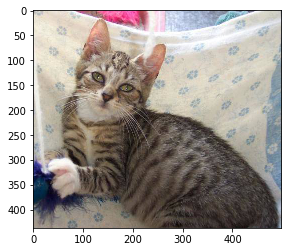

In [22]:
plt.imshow(img)

In [24]:
img.shape

(437, 499, 3)

In [25]:
img[:4, :4]

array([[[211, 211, 219],
        [210, 211, 216],
        [208, 207, 213],
        [202, 201, 206]],

       [[200, 201, 206],
        [199, 198, 204],
        [196, 195, 200],
        [193, 192, 197]],

       [[193, 192, 197],
        [189, 188, 193],
        [184, 183, 188],
        [185, 185, 187]],

       [[197, 195, 198],
        [189, 187, 190],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

# Train our model

In [6]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [7]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 293/360 [00:04<00:01, 62.69it/s, loss=0.531]


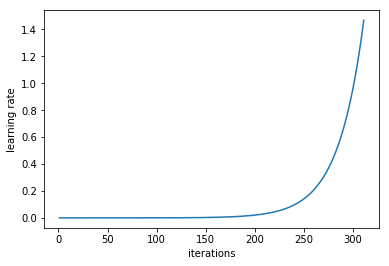

In [8]:
learn.sched.plot_lr()

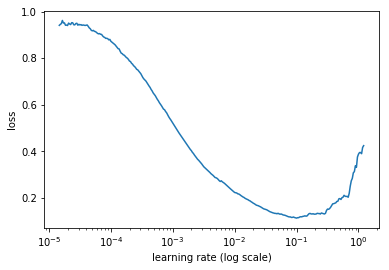

In [9]:
learn.sched.plot()

In [10]:
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.061167   0.030248   0.991211  
    1      0.049692   0.024918   0.992188                     



[0.02491771, 0.9921875]

# Data augmentation

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [12]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [13]:
ims = np.stack([get_augs() for i in range(6)])

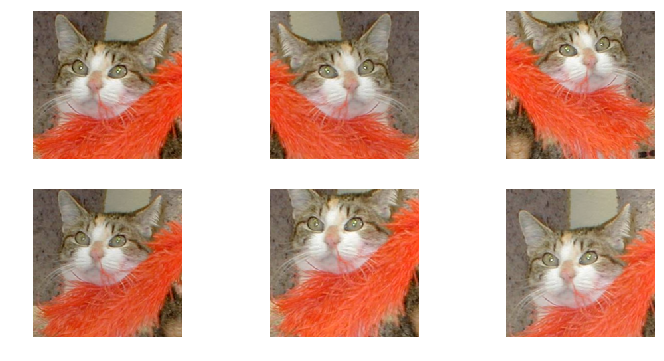

In [14]:
plots(ims, rows=2)

In [12]:
data = ImageClassifierData.from_paths(PATH, tfms = tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [17]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.04761    0.038276   0.98877   



[0.038276467, 0.98876953125]

In [13]:
learn.precompute=False

In [14]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.074669   0.031261   0.98877   
    1      0.050127   0.025079   0.991211                     
    2      0.045885   0.025531   0.991699                     



[0.025530778, 0.99169921875]

In [15]:
learn.save('224_lastlayer')

# fine tuning

In [16]:
learn.unfreeze()

In [17]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

 83%|████████▎ | 299/360 [02:38<00:32,  1.89it/s, loss=0.0484]

# Explore results

In [28]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [29]:
data.classes

['cats', 'dogs']

In [30]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [35]:
log_preds[:5]

array([[-0.00008, -9.46943],
       [-0.0131 , -4.34198],
       [-0.00086, -7.05902],
       [-0.00025, -8.30927],
       [-0.00012, -9.01699]], dtype=float32)

In [32]:
preds = np.argmax(log_preds, axis=1)

In [33]:
preds.shape

(2000,)

In [34]:
preds[:5]

array([0, 0, 0, 0, 0])

In [43]:
probsdog = np.exp(log_preds[:,1])
probscat = np.exp(log_preds[:,0])

In [42]:
probsdog[:5]

array([0.00008, 0.01301, 0.00086, 0.00025, 0.00012], dtype=float32)

In [44]:
probscat[:5]

array([0.99992, 0.98699, 0.99914, 0.99975, 0.99988], dtype=float32)

In [46]:
np.exp(-0.00008)

0.9999200031999147

In [47]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [48]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [49]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [50]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


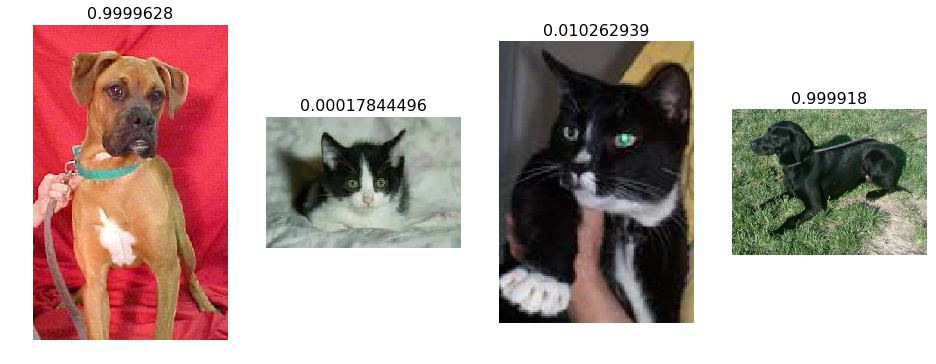

In [51]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


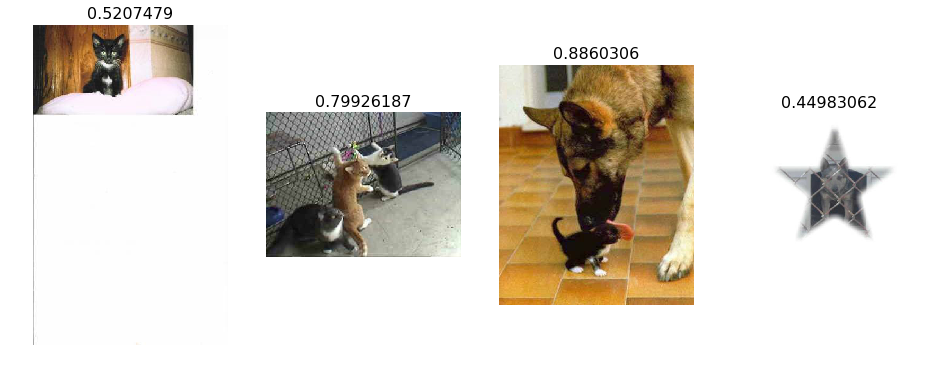

In [52]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [53]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


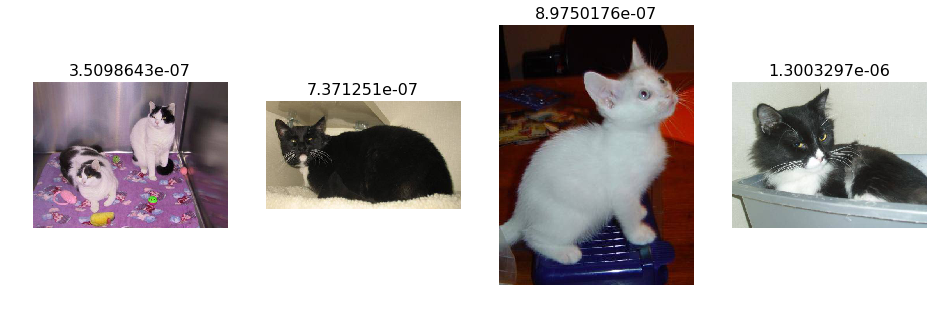

In [54]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

MOst correct dogs


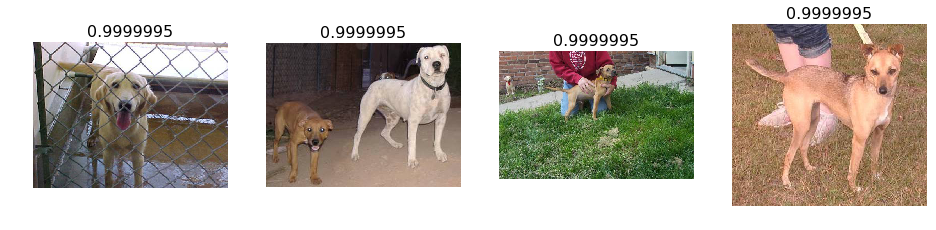

In [55]:
plot_val_with_title(most_by_correct(1, True), "MOst correct dogs")

Most incorrect cats


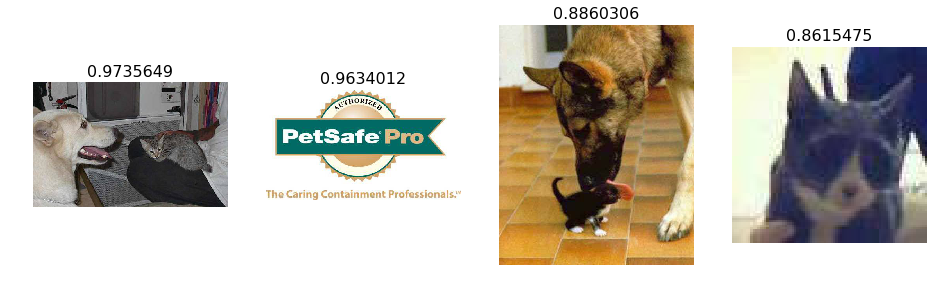

In [56]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


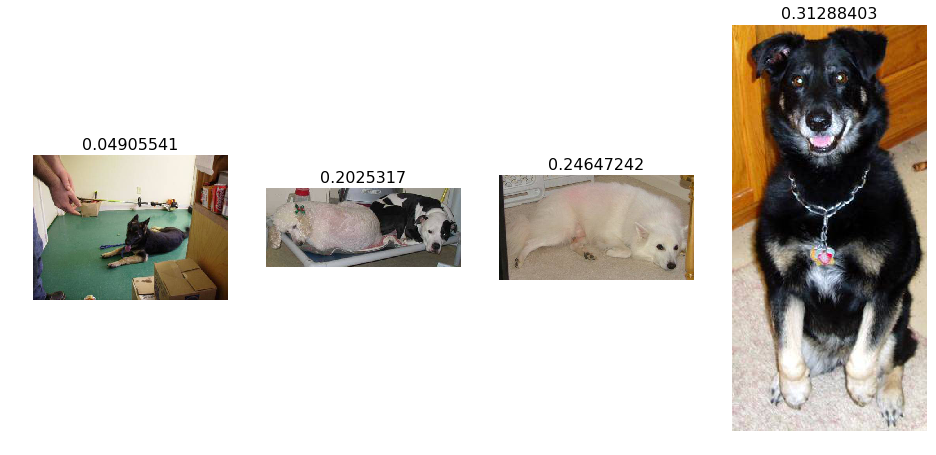

In [57]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


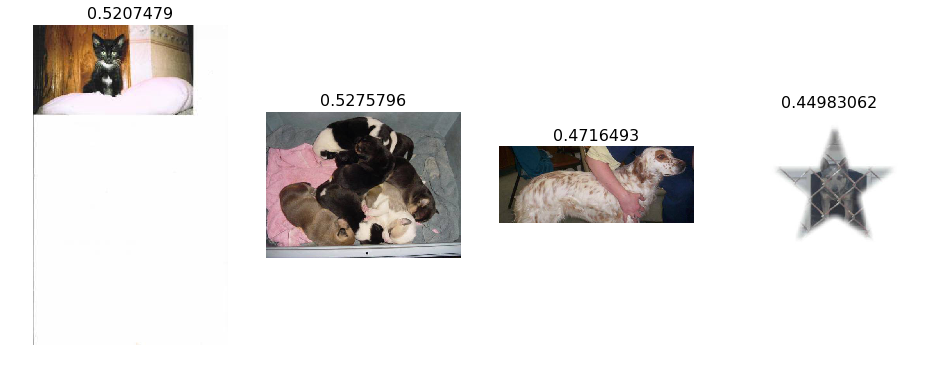

In [61]:
most_uncertain = np.argsort(np.abs(probscat - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")